# 4. Performance

## Imports

In [3]:
%matplotlib inline

import glob
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

if int(os.environ.get("MODERN_PANDAS_EPUB", 0)):
    import prep  # noqa

sns.set_style("ticks")
sns.set_context("talk")
pd.options.display.max_rows = 10

## Constructors

When combining many data sources—such as CDs—you can either:

1. Initialize one DataFrame and append to it
2. Make many small DataFrames and concatenate at the end

Second method is faster.

In [23]:
# Python (bad) way
files = glob.glob("data/weather/*.csv")
columns = [
    "station",
    "date",
    "tmpf",
    "relh",
    "sped",
    "mslp",
    "p01i",
    "vsby",
    "gust_mph",
    "skyc1",
    "skyc2",
    "skyc3",
]
# init empty DataFrame, like you might for a list
weather = pd.DataFrame(columns=columns)
for fp in files:
    city = pd.read_csv(fp, usecols=columns)
    weather = weather.append(city)

In [32]:
# Pandas (good) way
files = glob.glob("data/weather/*.csv")
weather_dfs = [pd.read_csv(fp, names=columns, header=0) for fp in files]
weather = pd.concat(weather_dfs)

Can compare two different ways of building a DataFrame—`append_df` and `concat_df`.

In [35]:
import time

size_per = 5000
N = 100
cols = list("abcd")


def timed(n=30):
    """
    Running a microbenchmark. Never use this.
    """

    def deco(func):
        def wrapper(*args, **kwargs):
            timings = []
            for i in range(n):
                t0 = time.time()
                func(*args, **kwargs)
                t1 = time.time()
                timings.append(t1 - t0)
            return timings

        return wrapper

    return deco


@timed(60)
def append_df():
    """
    The pythonic (bad) way
    """
    df = pd.DataFrame(columns=cols)
    for _ in range(N):
        df.append(pd.DataFrame(np.random.randn(size_per, 4), columns=cols))
    return df


@timed(60)
def concat_df():
    """
    The pandorabe (good) way
    """
    dfs = [pd.DataFrame(np.random.randn(size_per, 4), columns=cols) for _ in range(N)]
    return pd.concat(dfs, ignore_index=True)

In [36]:
t_append = append_df()
t_concat = concat_df()

timings = (
    pd.DataFrame({"Append": t_append, "Concat": t_concat})
    .stack()
    .reset_index()
    .rename(columns={0: "Time (s)", "level_1": "Method"})
)
timings.head()

,level_0,Method,Time (s)
0,0,Append,0.183432
1,0,Concat,0.112763
2,1,Append,0.155029
3,1,Concat,0.098710
4,2,Append,0.155059


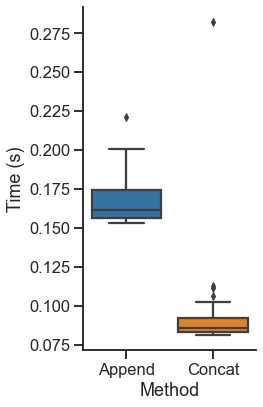

In [37]:
plt.figure(figsize=(4, 6))
sns.boxplot(x="Method", y="Time (s)", data=timings)
sns.despine()
plt.tight_layout()

## Datatype

Pandas types are NumPys with some extensions—`categorical`, `datetime64`, and `timedelta64`. All columns should be same type. If that's not possible, it will have an `object` type.

Traditional Pandas `NA` is a float. So if you have missing values with an integer column it will be an `object`. Text data will be an `object` column as well. There is no native `date` type—but it's usually okay to just use `datetime`.

Good conversions methods are

- `to_numeric`
- `to_datetime`
- `to_timedelta`

## Iteration, apply, and vectorization

<div class="alert alert-block alert-info">
    <b>Techniques of note</b>
    <br><br>
    <li><b><code>.from_product</code></b> to get possible combinations of MultiIndex</li>
    <li><b><code>.add_suffix</code></b> to add a suffix to column names</li>
    <li><b><code>.reindex</code></b> to assign indexes to a DataFrame. Use level argument to assign MultiIndex to single-level indexes</li>
    <li><b><code>.itertuples</code></b> for iterating over DataFrame rows as namedtuples.</li>
    <li><b><code>.transform</code></b> is used for applying a function to a GroupBy object. Note that this will return values in the original DataFrame dimension.</li>
</div>

In [46]:
df = pd.read_csv("data/307021124_T_ONTIME.csv")
delays = df["DEP_DELAY"]

Example: Get top values, _then_ sort.

In [47]:
delays.nlargest(5).sort_values()

116358    1480.0
149828    1545.0
148904    1934.0
61662     1970.0
54015     2755.0
Name: DEP_DELAY, dtype: float64

In [45]:
delays.nsmallest(5).sort_values()

296949   -59.0
235544   -58.0
197476   -56.0
326579   -56.0
345488   -55.0
Name: DEP_DELAY, dtype: float64

In [48]:
%timeit delays.sort_values().tail(5)

34.2 ms ± 617 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
%timeit delays.nlargest(5).sort_values()

8.02 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [1]:
from utils import download_airports
import zipfile
if not os.path.exists("data/airports.csv.zip"):
    download_airports()

In [2]:
coord = (
    pd.read_csv(
        "data/airports.csv.zip",
        index_col=["AIRPORT"],
        usecols=["AIRPORT", "LATITUDE", "LONGITUDE"],
    )
    .groupby(level=0)
    .first()
    .dropna()
    .sample(n=500, random_state=42)
    .sort_index()
)

coord.head()

,LATITUDE,LONGITUDE
AIRPORT,,
2CA,35.745556,-119.236389
6B0,43.984722,-73.095833
A06,65.655556,-165.356389
A13,61.390278,-157.995556
A25,59.288333,-136.173889


In [14]:
coord

,LATITUDE,LONGITUDE
AIRPORT,,
2CA,35.745556,-119.236389
6B0,43.984722,-73.095833
A06,65.655556,-165.356389
A13,61.390278,-157.995556
A25,59.288333,-136.173889
...,...,...
ZAM,6.923056,122.058889
ZKP,-12.572778,27.893889
ZTS,49.916944,-126.650000


In [15]:
coord.reindex(idx, level="origin")

LATITUDE   LONGITUDE
origin dest                       
2CA    2CA   35.745556 -119.236389
       6B0   35.745556 -119.236389
       A06   35.745556 -119.236389
       A13   35.745556 -119.236389
       A25   35.745556 -119.236389
...                ...         ...
ZTS    ZXM   49.916944 -126.650000
       ZXX   49.916944 -126.650000
ZXM    ZXM   55.408611 -132.329167
       ZXX   55.408611 -132.329167
ZXX    ZXX   46.218333 -119.209444

[125250 rows x 2 columns]

In [8]:
idx = pd.MultiIndex.from_product([coord.index, coord.index], names=["origin", "dest"])
pairs = pd.concat(
    [
        coord.add_suffix("_1").reindex(idx, level="origin"),
        coord.add_suffix("_2").reindex(idx, level="dest"),
    ],
    axis=1
)
pairs.head()

LATITUDE_1  LONGITUDE_1  LATITUDE_2  LONGITUDE_2
origin dest                                                  
2CA    2CA    35.745556  -119.236389   35.745556  -119.236389
       6B0    35.745556  -119.236389   43.984722   -73.095833
       A06    35.745556  -119.236389   65.655556  -165.356389
       A13    35.745556  -119.236389   61.390278  -157.995556
       A25    35.745556  -119.236389   59.288333  -136.173889

In [11]:
idx = idx[idx.get_level_values(0) <= idx.get_level_values(1)]
len(idx)

125250

Alternate implementation. Slower.

In [ ]:
# Version not leveraging indexes
from itertools import product, chain

coord2 = coord.reset_index()
x = product(
    coord2.add_suffix("_1").itertuples(index=False),
    coord2.add_suffix("_2").itertuples(index=False),
)
y = [list(chain.from_iterable(z)) for z in x]

df2 = pd.DataFrame(
    y,
    columns=[
        "origin",
        "LATITUDE_1",
        "LONGITUDE_1",
        "dest",
        "LATITUDE_1",
        "LONGITUDE_2",
    ],
).set_index(["origin", "dest"])
df2.head()

"Python" vs NumPy

In [17]:
import math


def gcd_py(lat1, lng1, lat2, lng2):
    """
    Calculate great circle distance between two points.
    http://www.johndcook.com/blog/python_longitude_latitude/

    Parameters
    ----------
    lat1, lng1, lat2, lng2: float

    Returns
    -------
    distance:
      distance from ``(lat1, lng1)`` to ``(lat2, lng2)`` in kilometers.
    """
    # python2 users will have to use ascii identifiers (or upgrade)
    degrees_to_radians = math.pi / 180.0
    ϕ1 = (90 - lat1) * degrees_to_radians
    ϕ2 = (90 - lat2) * degrees_to_radians

    θ1 = lng1 * degrees_to_radians
    θ2 = lng2 * degrees_to_radians

    cos = math.sin(ϕ1) * math.sin(ϕ2) * math.cos(θ1 - θ2) + math.cos(ϕ1) * math.cos(ϕ2)
    # round to avoid precision issues on identical points causing ValueErrors
    cos = round(cos, 8)
    arc = math.acos(cos)
    return arc * 6373  # radius of earth, in kilometers

In [18]:
def gcd_vec(lat1, lng1, lat2, lng2):
    """
    Calculate great circle distance.
    http://www.johndcook.com/blog/python_longitude_latitude/

    Parameters
    ----------
    lat1, lng1, lat2, lng2: float or array of float

    Returns
    -------
    distance:
      distance from ``(lat1, lng1)`` to ``(lat2, lng2)`` in kilometers.
    """
    # python2 users will have to use ascii identifiers
    ϕ1 = np.deg2rad(90 - lat1)
    ϕ2 = np.deg2rad(90 - lat2)

    θ1 = np.deg2rad(lng1)
    θ2 = np.deg2rad(lng2)

    cos = np.sin(ϕ1) * np.sin(ϕ2) * np.cos(θ1 - θ2) + np.cos(ϕ1) * np.cos(ϕ2)
    arc = np.arccos(cos)
    return arc * 6373

Iteration vs `.apply`

In [ ]:
pairs.itertuples

In [23]:
%%time
# Iteration
pd.Series([gcd_py(*x) for x in pairs.itertuples(index=False)], index=pairs.index)

CPU times: user 644 ms, sys: 8.9 ms, total: 653 ms
Wall time: 651 ms


origin  dest
2CA     2CA         0.000000
        6B0      3989.980668
        A06      4467.962648
        A13      3928.909755
        A25      2892.150496
                    ...     
ZXX     ZAM     11576.021492
        ZKP     15171.957080
        ZTS       688.749534
        ZXM      1372.172407
        ZXX         0.000000
Length: 250000, dtype: float64

In [24]:
%%time
# ``.apply``
r = pairs.apply(
    lambda x: gcd_py(
        x["LATITUDE_1"], x["LONGITUDE_1"], x["LATITUDE_2"], x["LONGITUDE_2"]
    ),
    axis=1,
);

CPU times: user 25.4 s, sys: 105 ms, total: 25.5 s
Wall time: 25.6 s


`.apply` is _way_ slower. You rarely want to use `.apply` and even less so with `axis=1`. Write functions that take in arrays and pass those directly.

In [27]:
%%time
# Best version
r = gcd_vec(
    pairs["LATITUDE_1"], pairs["LONGITUDE_1"], pairs["LATITUDE_2"], pairs["LONGITUDE_2"]
)

CPU times: user 41.8 ms, sys: 4.21 ms, total: 46 ms
Wall time: 30.8 ms


Some operations are a little bit tricker to vectorize.

In [36]:
import random


def create_frame(n, n_groups):
    # just setup code, not benchmarking this
    stamps = pd.date_range("20010101", periods=n, freq="ms")
    random.shuffle(stamps.values)
    return pd.DataFrame(
        {
            "name": np.random.randint(0, n_groups, size=n),
            "stamp": stamps,
            "value": np.random.randint(0, n, size=n),
            "value2": np.random.randn(n),
        }
    )


df = create_frame(1000000, 10000)


def f_apply(df):
    # Typical transform
    return df.groupby("name").value2.apply(lambda x: (x - x.mean()) / x.std())


def f_unwrap(df):
    # "unwrapped"
    g = df.groupby("name").value2
    v = df.value2
    return (v - g.transform(np.mean)) / g.transform(np.std)

In [30]:
%timeit f_apply(df)

5.54 s ± 76.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%timeit f_unwrap(df)

53 ms ± 253 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Pandas `GroupBy` will intercept calls for common functions like mean, std, and sum and use optimized Cython versions. Note that `GroupBy.apply` exists for flexibility, but is not the fastest.

## Categoricals

Good way to represent strings with few unique values.

In [52]:
import string

s = pd.Series(np.random.choice(list(string.ascii_letters), 100000))
print("{:0.2f} KB".format(s.memory_usage(index=False) / 1000))

800.00 KB


In [53]:
c = s.astype("category")
print("{:0.2f} KB".format(c.memory_usage(index=False) / 1000))

102.98 KB
